In [1]:
# %pip install numpy Pillow

import numpy as np
import os
import PIL
import PIL.Image


In [3]:
# # %%
# %pip install pandas matplotlib scikit-learn opencv-python

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2


In [4]:
# %%
data_dir = r"Train"
categories = ['real', 'fake']
img_size = 128


In [5]:
# %%
def load_images(data_dir, categories, img_size):
    data = []
    for category in categories:
        folder = os.path.join(data_dir, category)
        label = categories.index(category)  # 0 for real, 1 for fake
        for file in os.listdir(folder):
            if file.lower().endswith(".jpg"):
                try:
                    path = os.path.join(folder, file)
                    img = cv2.imread(path)
                    img = cv2.resize(img, (img_size, img_size))
                    data.append([img, label])
                except Exception as e:
                    print(f"Error loading {file}: {e}")
    return data


In [6]:
# %%
import random

# Ensure the os module is available
import os

dataset = load_images(data_dir, categories, img_size)
random.shuffle(dataset)

In [7]:
print(f"Total images loaded: {len(dataset)}")

Total images loaded: 140002


In [9]:
import numpy as np

def data_generator(dataset, img_size, batch_size=32):
    X_batch, y_batch = [], []
    while True:
        for img, label in dataset:
            X_batch.append(img / 255.0)  # Normalize to [0,1]
            y_batch.append(label)
            if len(X_batch) == batch_size:
                yield (np.array(X_batch, dtype=np.float32).reshape(-1, img_size, img_size, 3),
                       np.array(y_batch, dtype=np.int32))
                X_batch, y_batch = [], []

        # Yield the last remaining batch (if it's not empty)
        if X_batch:
            yield (np.array(X_batch, dtype=np.float32).reshape(-1, img_size, img_size, 3),
                   np.array(y_batch, dtype=np.int32))
            X_batch, y_batch = [], []  # Reset for next epoch



In [10]:
# %%
import random

random.shuffle(dataset)
print(f"Total samples: {len(dataset)}")


Total samples: 140002


In [11]:
# %%
X = []
y = []

for image, label in dataset:
    X.append(image)
    y.append(label)

print(f"Number of images: {len(X)}, Number of labels: {len(y)}")


Number of images: 140002, Number of labels: 140002


In [13]:
import numpy as np
import os

# Create a folder to save batches
os.makedirs("saved_batches", exist_ok=True)

batch_size = 10000
for i in range(0, len(X), batch_size):
    X_batch = np.array(X[i:i+batch_size], dtype=np.uint8)
    y_batch = np.array(y[i:i+batch_size])

    np.save(f"saved_batches/X_batch_{i//batch_size}.npy", X_batch)
    np.save(f"saved_batches/y_batch_{i//batch_size}.npy", y_batch)

    print(f"Saved batch {i//batch_size} — {len(X_batch)} samples")


Saved batch 0 — 10000 samples
Saved batch 1 — 10000 samples
Saved batch 2 — 10000 samples
Saved batch 3 — 10000 samples
Saved batch 4 — 10000 samples
Saved batch 5 — 10000 samples
Saved batch 6 — 10000 samples
Saved batch 7 — 10000 samples
Saved batch 8 — 10000 samples
Saved batch 9 — 10000 samples
Saved batch 10 — 10000 samples
Saved batch 11 — 10000 samples
Saved batch 12 — 10000 samples
Saved batch 13 — 10000 samples
Saved batch 14 — 2 samples


In [14]:
# %%
# Process the dataset in smaller chunks to avoid MemoryError
def normalize_in_batches(dataset, batch_size):
	for i in range(0, len(dataset), batch_size):
		batch = dataset[i:i + batch_size]
		batch_images = np.array([img for img, label in batch], dtype=np.float32) / 255.0
		batch_labels = np.array([label for img, label in batch], dtype=np.int32)
		yield batch_images, batch_labels

# Example usage
normalized_batches = normalize_in_batches(dataset, batch_size=32)
first_batch_images, first_batch_labels = next(normalized_batches)
print(f"First batch shape: {first_batch_images.shape}, Labels shape: {first_batch_labels.shape}")


First batch shape: (32, 128, 128, 3), Labels shape: (32,)


In [15]:
# %%
from sklearn.model_selection import train_test_split

# Ensure X and y are populated with data
if len(X) == 0 or len(y) == 0:
    raise ValueError("X and y are empty. Please ensure they are populated with data before splitting.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 112001, Testing samples: 28001


In [ ]:
# Install TensorFlow if not already installed
# %pip install tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10,
                                   zoom_range=0.1, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)


In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [18]:
# Define directories for training and testing data
train_dir = r"Train"
test_dir = r"Test"

# Normalize pixel values between 0 and 1
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create batches
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)

Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output: Real or Fake
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\priya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Accuracy plot
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Test Accuracy')
# plt.legend()
# plt.show()

# # Loss plot
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Test Loss')
# plt.legend()
# plt.show()

In [24]:
model.save('deepfake_detection_model.h5')

In [54]:
print("Raw Prediction Output:", prediction)


Raw Prediction Output: [[0.16755861]]


In [27]:
import os

real_path = r'Train\Real'
fake_path = r'Train\Fake'

print("REAL images:", len(os.listdir(real_path)))
print("FAKE images:", len(os.listdir(fake_path)))


REAL images: 70001
FAKE images: 70001


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Reinitialize the model
model = Sequential()

# Add the final layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [31]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    r'Train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    r'Train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

model.fit(train_gen, validation_data=val_gen, epochs=5)


Found 112002 images belonging to 2 classes.
Found 28000 images belonging to 2 classes.
Epoch 1/5
3501/3501 ━━━━━━━━━━━━━━━━━━━━ 3723s 1s/step - accuracy: 0.7614 - loss: 0.4819 - val_accuracy: 0.7956 - val_loss: 0.4269
Epoch 2/5
3501/3501 ━━━━━━━━━━━━━━━━━━━━ 758s 217ms/step - accuracy: 0.8108 - loss: 0.4023 - val_accuracy: 0.8044 - val_loss: 0.4125
Epoch 3/5
3501/3501 ━━━━━━━━━━━━━━━━━━━━ 710s 203ms/step - accuracy: 0.8196 - loss: 0.3875 - val_accuracy: 0.8068 - val_loss: 0.4058
Epoch 4/5
3501/3501 ━━━━━━━━━━━━━━━━━━━━ 721s 206ms/step - accuracy: 0.8253 - loss: 0.3779 - val_accuracy: 0.8117 - val_loss: 0.4004
Epoch 5/5
3501/3501 ━━━━━━━━━━━━━━━━━━━━ 735s 210ms/step - accuracy: 0.8328 - loss: 0.3647 - val_accuracy: 0.8106 - val_loss: 0.3972



  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


c:\Users\priya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


341/341 ━━━━━━━━━━━━━━━━━━━━ 159s 464ms/step
              precision    recall  f1-score   support

           0       0.68      0.80      0.74      5492
           1       0.75      0.62      0.68      5413

    accuracy                           0.71     10905
   macro avg       0.72      0.71      0.71     10905
weighted avg       0.72      0.71      0.71     10905



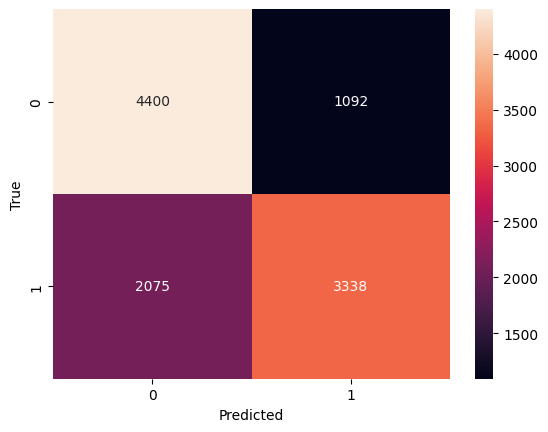

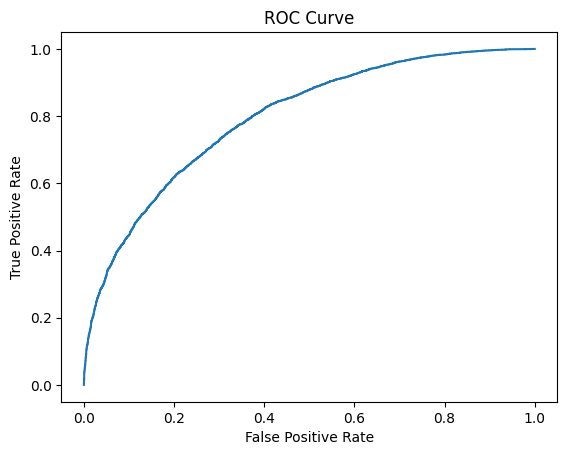

ROC AUC Score: 0.7955274178090054


In [ ]:
# %pip install seaborn

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Define test_generator if not already defined
if 'test_generator' not in locals():
	test_dir = r"Test"
	test_datagen = ImageDataGenerator(rescale=1./255)
	test_generator = test_datagen.flow_from_directory(
		test_dir,
		target_size=(128, 128),
		batch_size=32,
		class_mode='binary',
		shuffle=False  # Important for evaluation
	)

# Predict on test data
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")

# True labels from the test generator
y_test = test_generator.classes

# Classification report
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# AUC Score
print('ROC AUC Score:', roc_auc_score(y_test, y_pred))

In [34]:
model.save('deepfake_detection_model.h5')

In [35]:
import os

real_path = r'Train\Real'
fake_path = r'Train\Fake'

print("REAL images:", len(os.listdir(real_path)))
print("FAKE images:", len(os.listdir(fake_path)))


REAL images: 70001
FAKE images: 70001


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np


img = image.load_img(r'Test\Fake\fake_0.jpg', target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  

# Predict
prediction = model.predict(img_array)

if prediction < 0.5:
    print('Prediction: FAKE')
else:
    print('Prediction: REAL')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction: FAKE


In [62]:
from tensorflow.keras.preprocessing import image
import numpy as np


img = image.load_img(r'Test\Real\real_1.jpg', target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  

# Predict
prediction = model.predict(img_array)

if prediction < 0.5:
    print('Prediction: FAKE')
else:
    print('Prediction: REAL')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediction: REAL
